# **Machine Learning-Based Classification of Aggregate Rock Data**

### **LIBRARY IMPORTS**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Preprocessing and Splitting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report

### **DATASET LOADING**

In [ ]:
# Load files
try:
    labels_df = pd.read_excel('/content/aggregateRockData.xlsx')
    features_df = pd.read_csv('/content/feature_presence540.txt', sep=r'\s+', header=None)
except FileNotFoundError:
    print("Error: Files not found. Please ensure the paths are correct.")
    # Creating empty dataframes to allow the script to continue for demonstration
    # In a real scenario, you would stop here.
    labels_df = pd.DataFrame(np.random.randint(1, 4, size=(480, 2)))
    labels_df[0] = np.tile(np.arange(1, 31), 16) # Mock Subtype
    features_df = pd.DataFrame(np.random.randint(0, 2, size=(480, 14)))
    features_df[2] = np.repeat(np.arange(1, 17), 30) # Mock Token

# Use only first 480 rows
labels_df = labels_df.iloc[:480, :]
features_df = features_df.iloc[:480, :]

# Extract what we need
y = labels_df.iloc[:, 1]         # column 2 = category number (1, 2, 3)
subtype = labels_df.iloc[:, 0]   # column 1 = subtype number (1-30)
tokens = features_df.iloc[:, 2]  # column 3 = token number (1-16)
X = features_df.iloc[:, 3:14]    # columns 4–14 = 11 rock features

# --- Rename feature columns for clarity ---
X.columns = ["angularFrag","roundedFrag",
              "straightStripes","curvedStripes","physLayers","veins",
              "oilyTexture","splotchyTexture","stCrystal","mcCrystal","sandyTexture"]
feature_names = list(X.columns)

# Combine into one DataFrame
rock_data = X.copy()
rock_data['Category'] = y.values
rock_data['Token'] = tokens.values
rock_data['Subtype'] = subtype.values 

# Save to a new CSV file
output_path = "/content/rock_data_cleaned.csv"
rock_data.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")
print("Rock Data Head:")
rock_data.head()

Cleaned dataset saved to: /content/rock_data_cleaned.csv
Rock Data Head:


,angularFrag,roundedFrag,straightStripes,curvedStripes,physLayers,veins,oilyTexture,splotchyTexture,stCrystal,mcCrystal,sandyTexture,Category,Token,Subtype
0,0.20,0.15,0.00,0.0,0.00,0.05,0.0,0.30,0.0,0.00,0.10,1,1,2
1,0.65,0.15,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.05,0.05,1,2,3
2,0.60,0.00,0.00,0.0,0.05,0.00,0.0,0.35,0.0,0.00,0.05,1,3,4
3,0.10,0.85,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.00,0.10,1,4,5
4,0.35,0.80,0.00,0.0,0.00,0.00,0.0,0.10,0.0,0.00,0.05,1,5,6


### **EDA: Statistical Analysis & Visualization**

#### **1. Displaying statistical values and checking the distribution for all features**

In [8]:
# Display statistical values for all attributes: including features and target
print("Descriptive Statistics:")
rock_data.describe()

Descriptive Statistics:


,curvedStripes,physLayers,veins,oilyTexture,splotchyTexture,stCrystal,mcCrystal,sandyTexture,Category,Subtype
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854,2.000000,241.541667
std,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149,0.817348,138.783404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,121.750000
50%,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000,2.000000,241.500000
75%,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000,3.000000,361.250000
max,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000,3.000000,501.000000



Feature Distributions (Histograms):


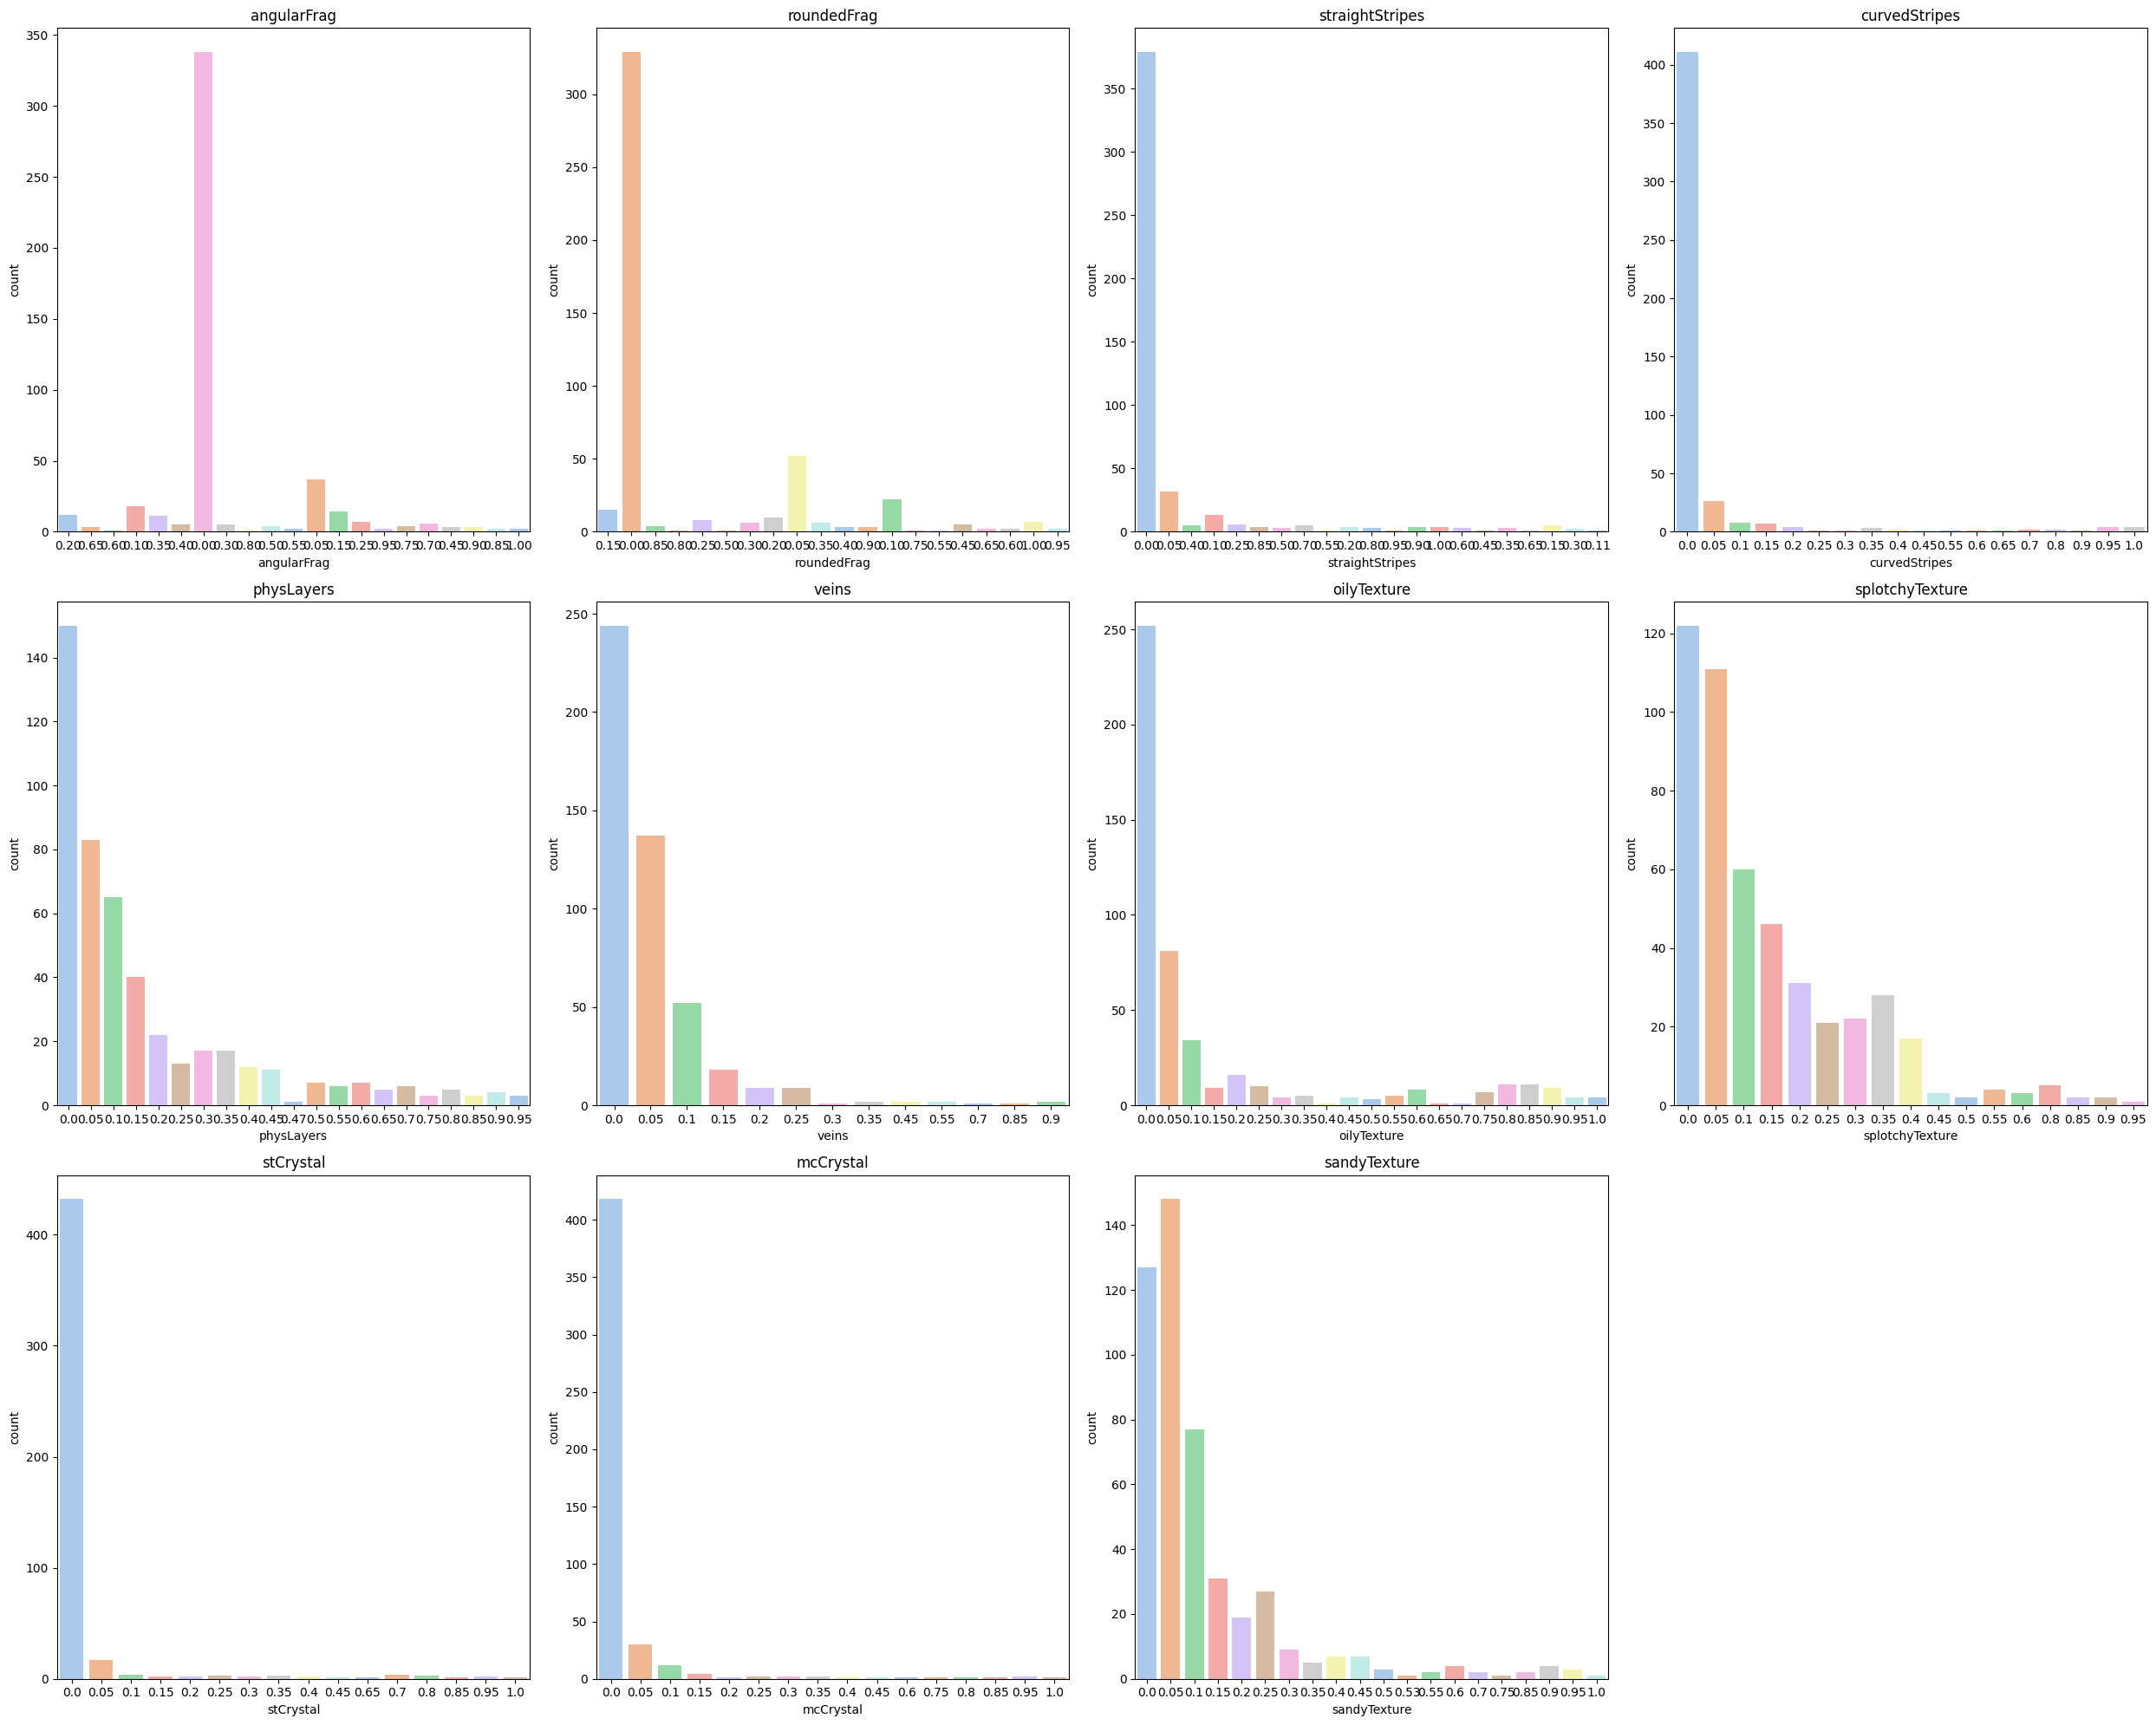

In [9]:
# Plot histograms for each feature
print("\nFeature Distributions (Histograms):")
plt.figure(figsize=(25, 20))
for i, col in enumerate(feature_names):
    plt.subplot(3, 4, i + 1)
    sns.countplot(x=col, data=rock_data, palette='pastel', hue=col, legend=False) # Changed palette to 'pastel'
    plt.title(col)
plt.tight_layout()
plt.show()

**Statistical Analysis & Distributions (from Histograms)**
The statistical analysis, confirmed by the histograms, provides a clear picture of our 11 features:

*   **Data Type**: The features are all *continuous-valued floats*, not simple binary 0/1 values.

*   **Range**: All features operate on a scale between *0.0 and 1.0*.

*   **Distribution**: The most critical observation is that all 11 features are *highly right-skewed*. The histograms for angularFrag, curvedStripes, stCrystal, mcCrystal, and others show a *massive bar at 0.0*, with a *long, thin tail* of non-zero values. This indicates that for any given rock, *most features are absent* (value of 0.0).



*   **Special treatment considerations**:

**Zero inflation / right skew**:
Most visual/geological features (e.g., curvedStripes, veins, oilyTexture, stCrystal) are extremely right-skewed, with median = 0.0 and a long tail of rare non-zero values. This means most rocks do not show that feature, and a few show it strongly.

Because of this, we may engineer binary presence/absence indicators (e.g. veins_present = 1 if veins > 0 else 0). This helps the model explicitly capture “feature appears vs doesn’t appear,” which seems geologically meaningful.

**Feature scaling for linear/SVM models**:
Although all features lie in [0, 1], they have different variances (for example, physLayers varies more than stCrystal). For models that are sensitive to feature scale (Logistic Regression / Softmax Regression and SVM), we should standardize the features (subtract mean, divide by std). This prevents higher-variance attributes from dominating the decision boundary. Random Forest does not require scaling.

**Class balance / weighting**:
We will inspect the distribution of the target classes (Category = {Igneous, Metamorphic, Sedimentary}). If one class is underrepresented, we may need to use class weights (e.g. class_weight='balanced') when training Logistic Regression and SVM, so that the model does not become biased toward the majority class.

**Low-variance / almost-always-zero features**:
Some features (e.g. stCrystal, mcCrystal) have very low means and are zero for most samples. These can behave like rare “signature” cues. We will monitor their importance in tree-based models. If a feature is effectively constant and does not help distinguish any class, we could consider removing it to reduce noise, but we should verify this using feature importance first.

In summary, the data is sparse and highly skewed. The two most important treatments are (a) adding binary presence flags for rare features, and (b) scaling/standardizing the numeric features before fitting Logistic Regression and SVM.



#### **2. Mapping the relationships between data attributes and between data attributes vs. label**

***Computing Pearson Correlation Coefficient (PCC) and generating a heatmap***

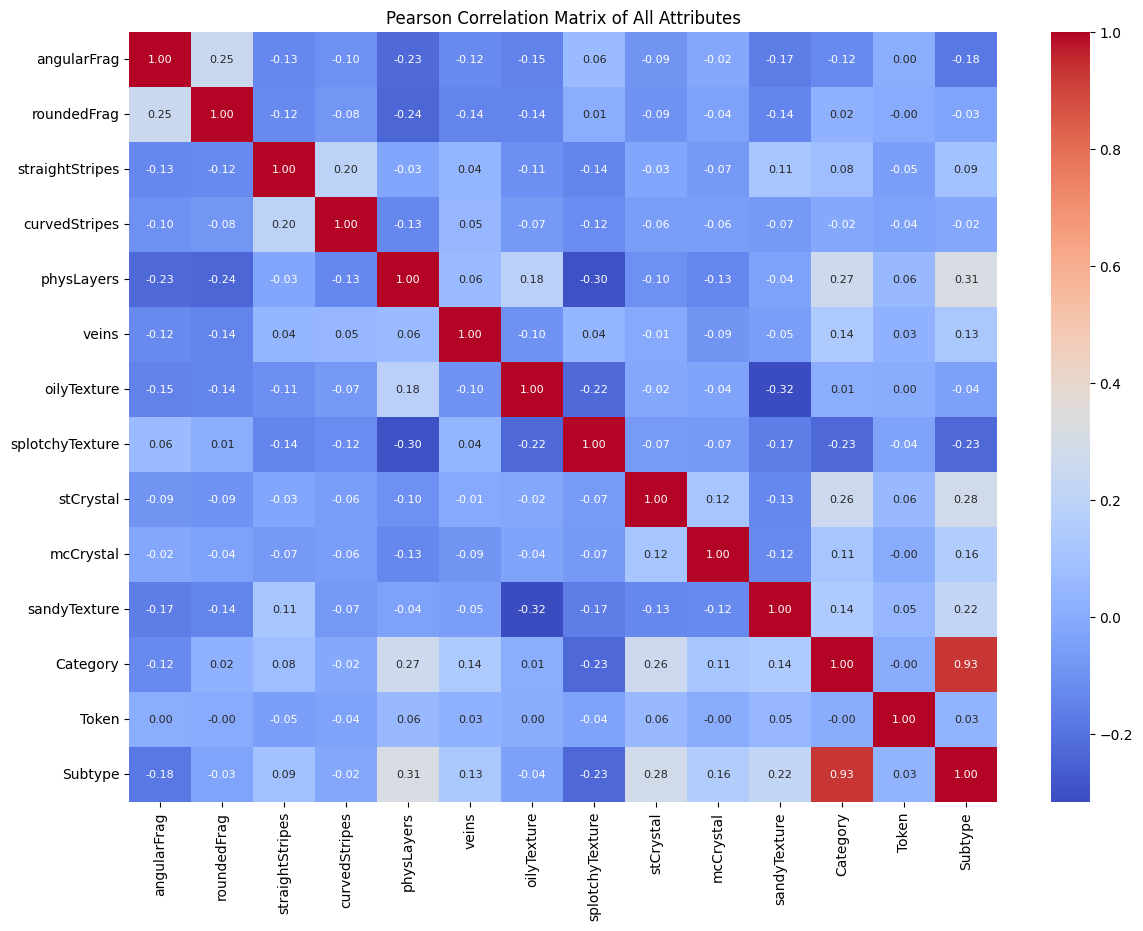

In [10]:
# Compute the Pearson Correlation Coefficient (PCC) matrix
corr_matrix = rock_data.corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
plt.title('Pearson Correlation Matrix of All Attributes')
plt.show()

In [35]:
corr = rock_data.corr()['Category'].sort_values(ascending=False)
print(corr)

Category                              1.000000e+00
Subtype                               9.330989e-01
physLayers                            2.661095e-01
stCrystal                             2.589103e-01
sandyTexture                          1.427949e-01
veins                                 1.417964e-01
mcCrystal                             1.138719e-01
straightStripes                       7.749481e-02
roundedFrag                           1.938458e-02
oilyTexture                           8.171521e-03
Token                                -9.502918e-16
curvedStripes                        -1.666106e-02
Model_Probability_Correct_Category   -9.396069e-02
angularFrag                          -1.204720e-01
splotchyTexture                      -2.300320e-01
Name: Category, dtype: float64


***Generating Scatter Plots***

In [11]:
import warnings
warnings.filterwarnings("ignore")



--- Generating Scatter Plots for All 11 Features vs. Category ---
All-features scatter plot grid saved to 'all_features_scatter.png'


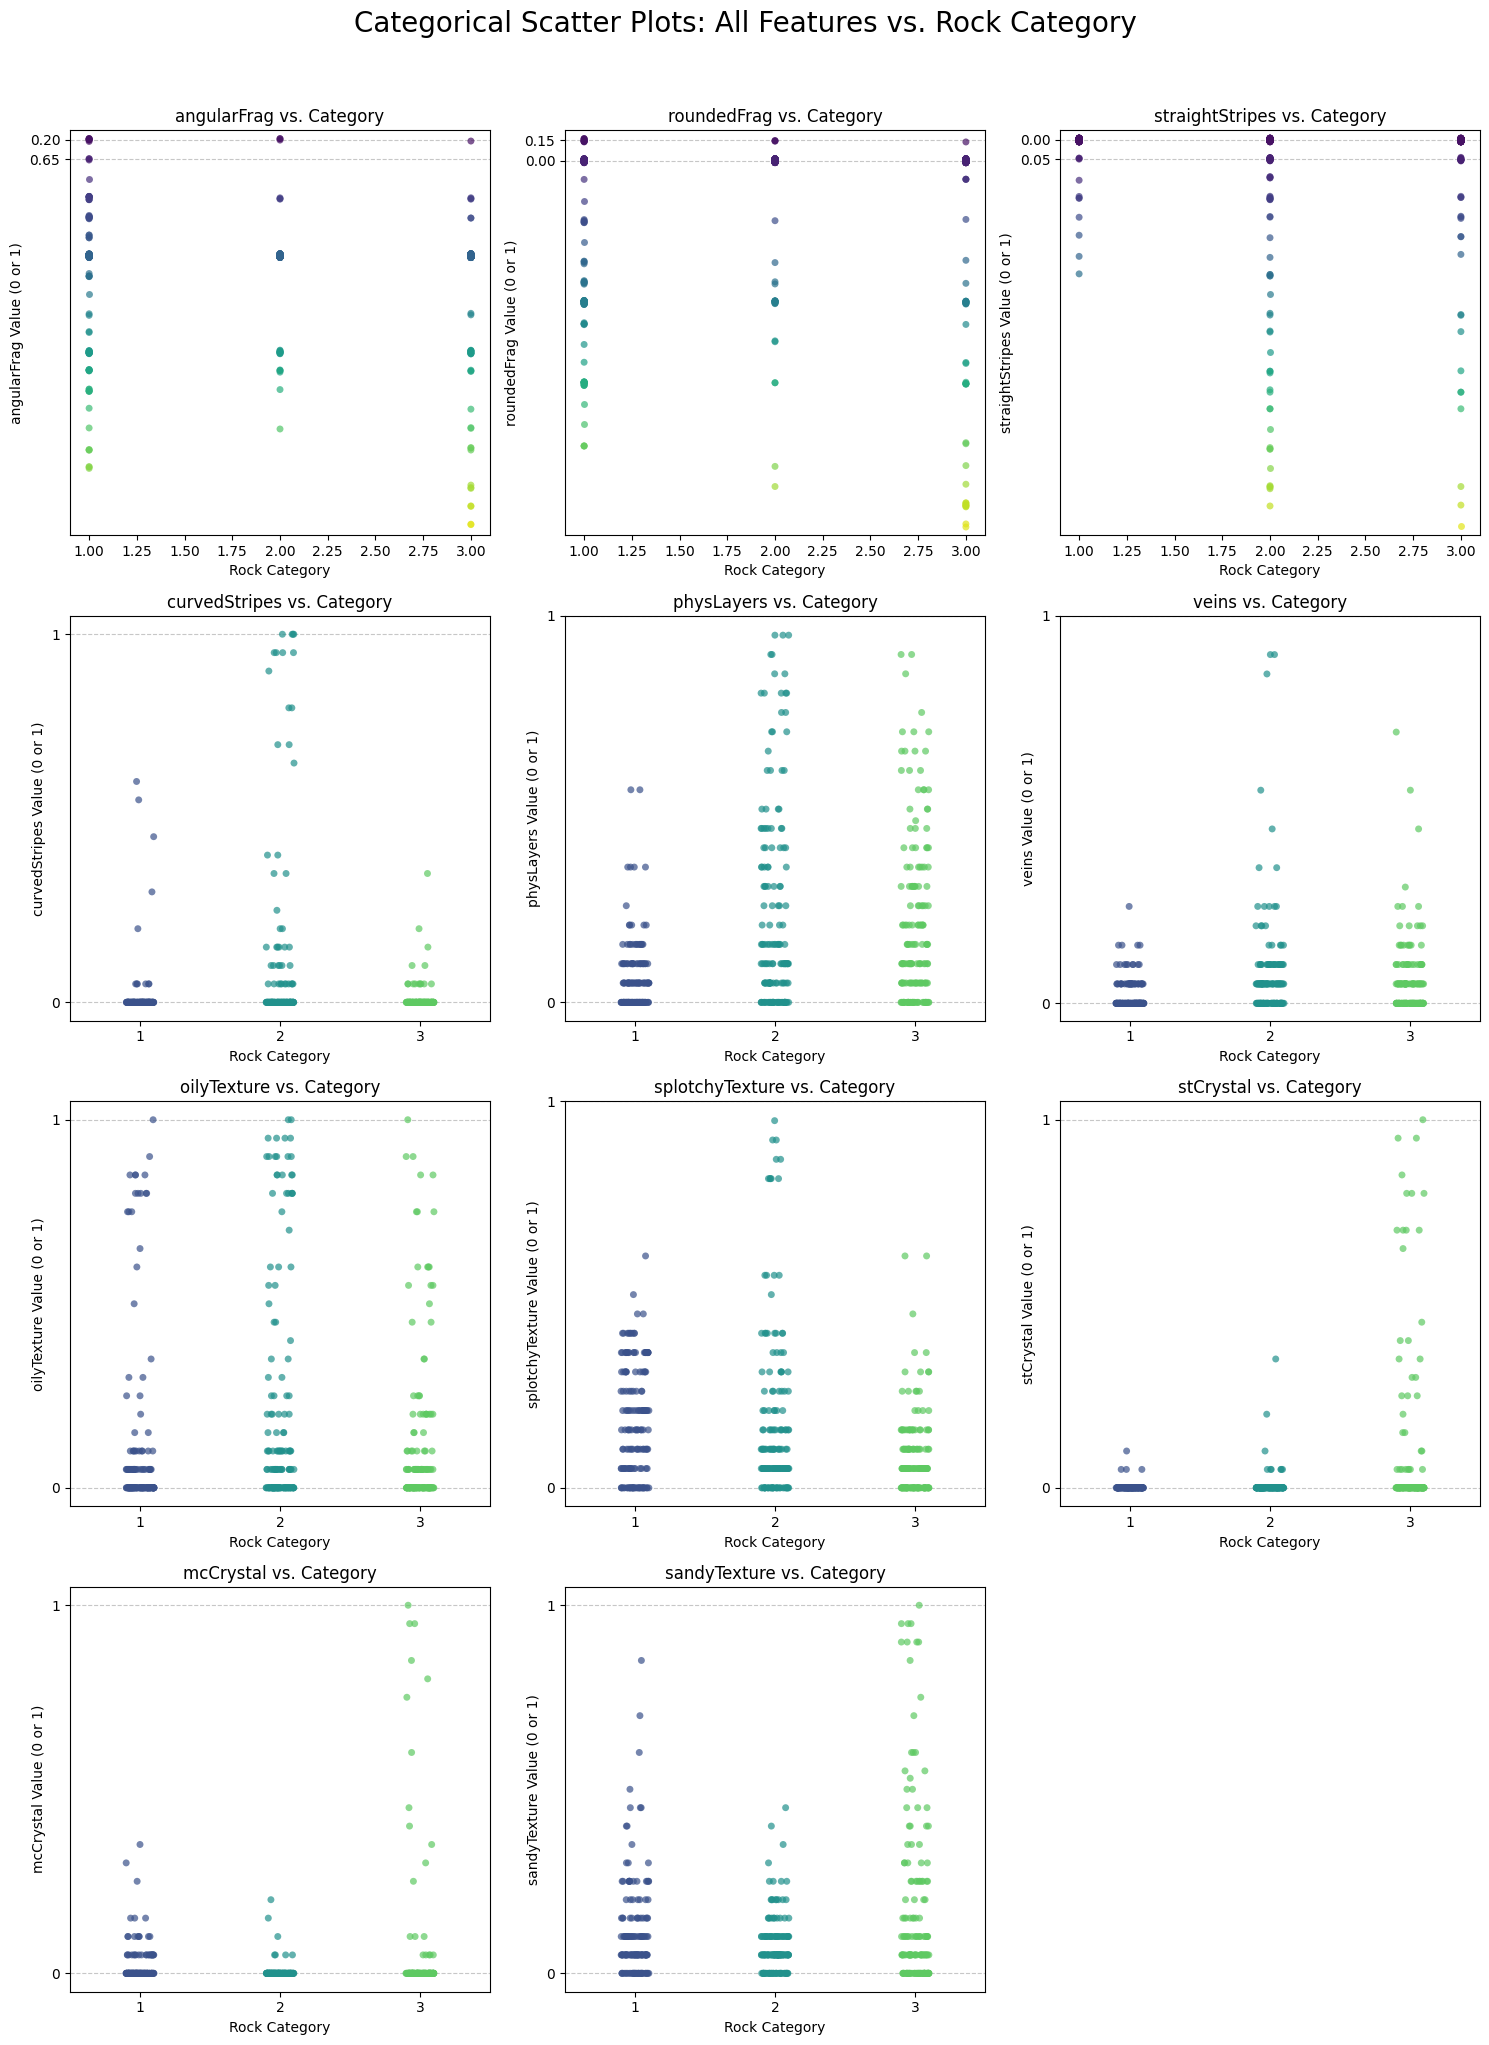

In [12]:
print("\n--- Generating Scatter Plots for All 11 Features vs. Category ---")

# Set up a 4-row, 3-column plot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

# Flatten the 4x3 'axes' array into a 1D array for easy looping
axes = axes.flatten()

# Loop through each feature and create a plot
for i, col in enumerate(feature_names):
    ax = axes[i]  # Get the current subplot
    sns.stripplot(data=rock_data,
                  x='Category',
                  y=col,
                  jitter=True,
                  palette='viridis',
                  ax=ax,
                  alpha=0.7) # Add some transparency

    ax.set_title(f'{col} vs. Category')
    ax.set_xlabel('Rock Category')
    ax.set_ylabel(f'{col} Value (0 or 1)')
    ax.set_yticks([0, 1])
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hide the 12th (unused) subplot
if len(feature_names) < len(axes):
    for j in range(len(feature_names), len(axes)):
        axes[j].set_visible(False)

# Add a main title for the entire figure
fig.suptitle('Categorical Scatter Plots: All Features vs. Rock Category', fontsize=20, y=1.02)

# Adjust layout to prevent plots from overlapping
fig.tight_layout()

# Save the figure
plt.savefig('all_features_scatter.png', bbox_inches='tight')
print("All-features scatter plot grid saved to 'all_features_scatter.png'")

# Display the plots
plt.show()

### Feature Relationships and Predictiveness

**Feature vs Feature:**  
- Most geological/visual features have very low correlation with each other (near 0 in the PCC heatmap), which means they carry mostly independent information.  
- There is no pair of normal features that is extremely redundant.  
- The one very strong relationship is between `Category` and `Subtype` (~0.93), which makes sense because each subtype belongs to exactly one main rock category. `Subtype` basically leaks the label and should not be used as an input feature when predicting `Category`.

**Feature vs Category (Label):**  
- Some features are clearly associated with specific rock types:
  - `physLayers`, `stCrystal`, and `sandyTexture` are positively correlated with `Category`, and their scatter plots show higher values mostly in Category 3 (Sedimentary).  
  - `angularFrag ` and `splotchyTexture` are negatively correlated with `Category`, and they appear more often in Category 1 (Igneous) and are mostly absent in Category 3.
- Other features (e.g., `veins`, `straightStripes`, `roundedFrag`) have weak correlation with `Category` and appear in all categories without a strong pattern.



### **DATA CLEANING**

#### **1. Assessment**

***Check for data types and missing values***

In [13]:
# Check for data types and missing values
print("--- Data Info ---")
rock_data.info()

print("\n--- Missing Values ---")
missing = rock_data.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   angularFrag      480 non-null    object 
 1   roundedFrag      480 non-null    object 
 2   straightStripes  480 non-null    object 
 3   curvedStripes    480 non-null    float64
 4   physLayers       480 non-null    float64
 5   veins            480 non-null    float64
 6   oilyTexture      480 non-null    float64
 7   splotchyTexture  480 non-null    float64
 8   stCrystal        480 non-null    float64
 9   mcCrystal        480 non-null    float64
 10  sandyTexture     480 non-null    float64
 11  Category         480 non-null    int64  
 12  Token            480 non-null    object 
 13  Subtype          480 non-null    int64  
dtypes: float64(8), int64(2), object(4)
memory usage: 52.6+ KB

--- Missing Values ---
No missing values found.


***Converting Data Types from object to numeric data type***

In [14]:
# Convert features to floats
column_dtypes = rock_data.dtypes
features_to_fix = column_dtypes[column_dtypes == 'object'].index.tolist()
for col in features_to_fix:
    rock_data[col] = pd.to_numeric(rock_data[col], errors='coerce')

# Convert Token to integer
rock_data['Token'] = rock_data['Token'].astype(int)

# (Optional) Check for any conversion errors (which would show as NaN)
if rock_data.isnull().any().any():
    print("WARNING: Errors during data type conversion created missing values (NaN).")
    # You might need to fill NaNs, e.g.: rock_data = rock_data.fillna(0)

print("\n--- Data Info After Fixing Types ---")
rock_data.info()


--- Data Info After Fixing Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   angularFrag      480 non-null    float64
 1   roundedFrag      480 non-null    float64
 2   straightStripes  480 non-null    float64
 3   curvedStripes    480 non-null    float64
 4   physLayers       480 non-null    float64
 5   veins            480 non-null    float64
 6   oilyTexture      480 non-null    float64
 7   splotchyTexture  480 non-null    float64
 8   stCrystal        480 non-null    float64
 9   mcCrystal        480 non-null    float64
 10  sandyTexture     480 non-null    float64
 11  Category         480 non-null    int64  
 12  Token            480 non-null    int64  
 13  Subtype          480 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 52.6 KB


***Check for duplicate rows***

In [15]:
# Check for duplicate rows
duplicates = rock_data.duplicated().sum()
print(f"\n--- Duplicates ---\nTotal duplicate rows: {duplicates}")


--- Duplicates ---
Total duplicate rows: 0


***Check for scale and distribution***

In [16]:
# Check for scale and distribution
print("--- Descriptive Statistics ---")

# Define feature columns
feature_names = [
    "angularFrag","roundedFrag",
    "straightStripes","curvedStripes","physLayers","veins",
    "oilyTexture","splotchyTexture","stCrystal","mcCrystal","sandyTexture"
]
  # assuming last two are Category, Token
print(rock_data[feature_names].describe().T)

--- Descriptive Statistics ---
                 count      mean       std  min  25%   50%     75%   max
angularFrag      480.0  0.084479  0.193996  0.0  0.0  0.00  0.0500  1.00
roundedFrag      480.0  0.080208  0.197648  0.0  0.0  0.00  0.0500  1.00
straightStripes  480.0  0.067729  0.194792  0.0  0.0  0.00  0.0000  1.00
curvedStripes    480.0  0.042292  0.160970  0.0  0.0  0.00  0.0000  1.00
physLayers       480.0  0.165146  0.216635  0.0  0.0  0.10  0.2125  0.95
veins            480.0  0.052396  0.102676  0.0  0.0  0.00  0.0500  0.90
oilyTexture      480.0  0.144479  0.265689  0.0  0.0  0.00  0.1000  1.00
splotchyTexture  480.0  0.141458  0.168222  0.0  0.0  0.10  0.2000  0.95
stCrystal        480.0  0.031667  0.135647  0.0  0.0  0.00  0.0000  1.00
mcCrystal        480.0  0.025104  0.112153  0.0  0.0  0.00  0.0000  1.00
sandyTexture     480.0  0.119854  0.173149  0.0  0.0  0.05  0.1500  1.00


**Data Quality and Cleanliness**
This dataset is in excellent condition for modeling. The `info()`, missing values, and duplicate checks show:

1.  **No Missing Values:** All 480 rows are complete for all 14 columns. No imputation or data-filling is needed.

2.  **Correct Data Types:** All 11 features are `float64`, and the identifiers/labels (`Category`, `Token`, `Subtype`) are `int64`. This is perfect for machine learning, and it confirms the previous "`object`" type issue has been successfully fixed.

3.  **No Duplicates:** There are zero duplicate rows in the dataset.

In summary, the data is clean, complete, and correctly formatted.

#### **3. Fix: Feature Scaling**

In [17]:
# ===============================
# 1. TRAIN / VAL / TEST SPLIT
# ===============================
# Rule from assignment:
#   train: Tokens 7-16
#   val:   Tokens 4-6
#   test:  Tokens 1-3

train_df = rock_data[ rock_data["Token"].between(7,16) ]
val_df   = rock_data[ rock_data["Token"].between(4,6)  ]
test_df  = rock_data[ rock_data["Token"].between(1,3)  ]

# Separate X and y for each split
X_train = train_df[feature_names].copy()
y_train = train_df["Category"].copy()

X_val   = val_df[feature_names].copy()
y_val   = val_df["Category"].copy()

X_test  = test_df[feature_names].copy()
y_test  = test_df["Category"].copy()

print("\nSplit sizes:")
print(f"Train: {len(X_train)} rows (Tokens 7-16)")
print(f"Val:   {len(X_val)} rows (Tokens 4-6)")
print(f"Test:  {len(X_test)} rows (Tokens 1-3)")
print("Total accounted for:", len(X_train)+len(X_val)+len(X_test))



Split sizes:
Train: 300 rows (Tokens 7-16)
Val:   90 rows (Tokens 4-6)
Test:  90 rows (Tokens 1-3)
Total accounted for: 480


In [18]:
# ===============================
# 2. SCALE FEATURES (for Logistic Regression / SVM)
#    - Fit ONLY on training set
#    - Apply same transform to val/test
# ===============================

scaler = StandardScaler()
scaler.fit(X_train)  # learn mean/std from TRAIN ONLY

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# We'll also make DataFrames (nice for plotting and inspection)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_scaled_df   = pd.DataFrame(X_val_scaled,   columns=feature_names)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=feature_names)

print("\nCheck scaling on one feature:")
feat0 = feature_names[0]
print(f"Original {feat0} mean (train): {X_train[feat0].mean():.4f}")
print(f"Scaled   {feat0} mean (train): {X_train_scaled_df[feat0].mean():.4f}")
print(f"Scaled   {feat0} std  (train): {X_train_scaled_df[feat0].std():.4f}")



Check scaling on one feature:
Original angularFrag mean (train): 0.0870
Scaled   angularFrag mean (train): -0.0000
Scaled   angularFrag std  (train): 1.0017


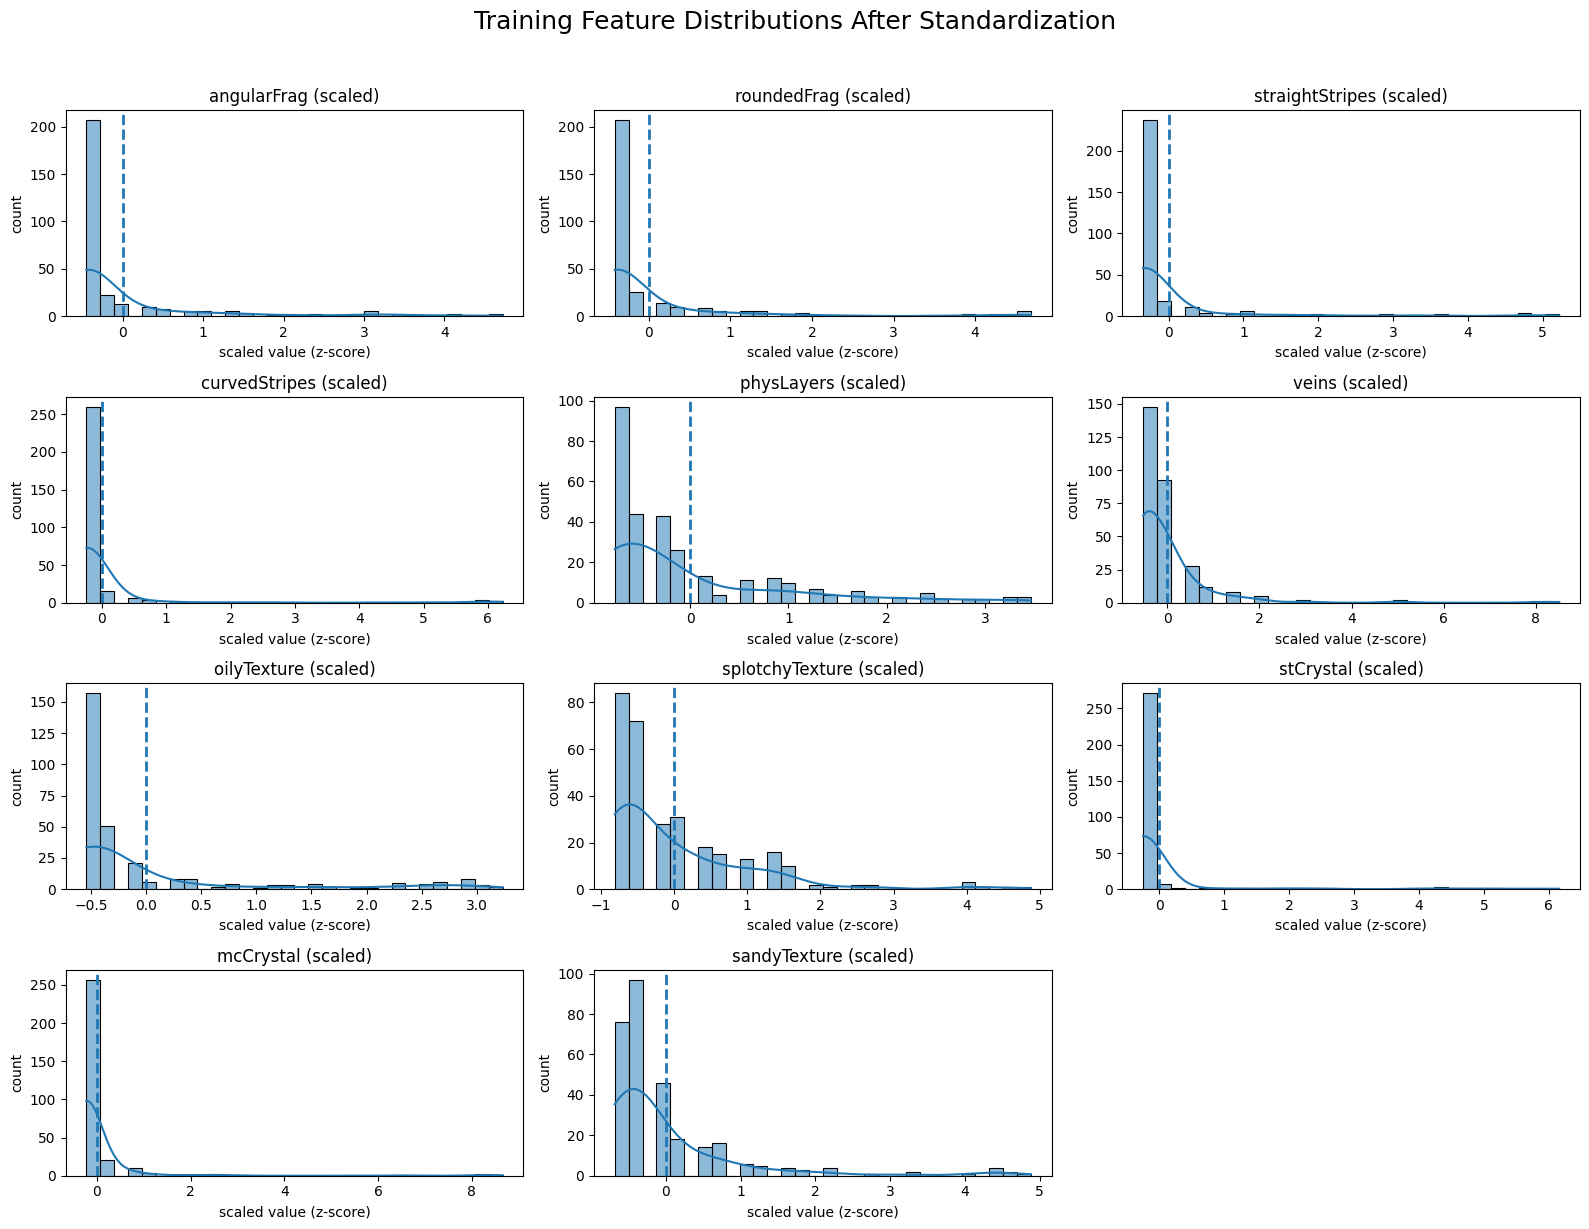

In [19]:
# ===============================
# 3. HISTOGRAMS AFTER SCALING
# ===============================

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(feature_names):
    ax = axes[i]
    sns.histplot(X_train_scaled_df[col], kde=True, bins=30, ax=ax)
    ax.axvline(x=0, linestyle="--", linewidth=2)  # mean ~0 after scaling
    ax.set_title(f"{col} (scaled)")
    ax.set_xlabel("scaled value (z-score)")
    ax.set_ylabel("count")

# hide any unused subplot (if 11 < 12 slots)
for j in range(len(feature_names), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Training Feature Distributions After Standardization", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()

In [20]:
# ===============================
# 4. PREDEFINEDSPLIT FOR GRIDSEARCHCV
#    We'll merge train+val so GridSearchCV can tune hyperparams
#    using *our* chosen validation set.
# ===============================

# Stack the scaled train and val for models that need scaling
X_train_val_scaled = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = pd.concat([y_train, y_val], ignore_index=True)

# Build test_fold: -1 means "this is training fold", 0 means "this is validation fold"
test_fold = np.concatenate([
    -1 * np.ones(len(X_train_scaled), dtype=int),
     0 * np.ones(len(X_val_scaled),   dtype=int)
])

ps = PredefinedSplit(test_fold)

print("\nPredefinedSplit ready.")
print("ps.test_fold[:20] =", test_fold[:20])
print("Counts: train fold =", np.sum(test_fold == -1), ", val fold =", np.sum(test_fold == 0))




PredefinedSplit ready.
ps.test_fold[:20] = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Counts: train fold = 300 , val fold = 90


### **MODELING AND COMPARISONS**

Train different classifiers and tweak the hyperparameters to improve performance

In [21]:
# --- Define Helper Function for Metrics ---
# This function will print a full report for train, validation, and test sets.
def print_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Prints classification reports for train, validation, and test sets."""

    # Get predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    print("--- Training Set Metrics ---")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(classification_report(y_train, y_pred_train, target_names=['Cat 1', 'Cat 2', 'Cat 3'], zero_division=0))

    print("---  Validation Set Metrics ---")
    print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
    print(classification_report(y_val, y_pred_val, target_names=['Cat 1', 'Cat 2', 'Cat 3'], zero_division=0))

    print("--- Test Set Metrics ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(classification_report(y_test, y_pred_test, target_names=['Cat 1', 'Cat 2', 'Cat 3'], zero_division=0))

# --- Prepare for GridSearch ---
# (This assumes your data from the previous steps is loaded)
# X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test
# feature_names
# ps (the PredefinedSplit object)
# X_train_val_scaled, y_train_val (the combined data for GridSearch)

# We need a dictionary to store our best models for the ensemble step
best_models = {}

print("Helper functions and variables ready.")

Helper functions and variables ready.


#### **1. Multinomial Logistic Regression (Softmax Regression)**
*Hyperparameters to explore: C, solver, max number of iterations*

In [22]:
print("--- 1. Training Multinomial Logistic Regression ---")

# Define the parameter grid to search
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000, 2500]
}

# Initialize the model
# multi_class='multinomial' makes it a Softmax Regression
lr = LogisticRegression(multi_class='multinomial', random_state=42)

# Initialize GridSearchCV
# We use cv=ps to use our custom validation set
lr_grid = GridSearchCV(estimator=lr,
                       param_grid=lr_param_grid,
                       cv=ps,
                       scoring='accuracy',
                       n_jobs=-1)

# Fit the grid search on the *combined* train-validation set
# The 'ps' object ensures it validates on the correct split
lr_grid.fit(X_train_val_scaled, y_train_val)

# Get the best model
best_lr = lr_grid.best_estimator_
best_models['LogisticRegression'] = best_lr

# --- Report Results ---
print(f"Best Parameters: {lr_grid.best_params_}")
print(f"Best Validation Accuracy: {lr_grid.best_score_:.4f}\n")

# Print full metrics for the best model
print_metrics(best_lr, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

--- 1. Training Multinomial Logistic Regression ---
Best Parameters: {'C': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}
Best Validation Accuracy: 0.6333

--- Training Set Metrics ---
Accuracy: 0.7000
              precision    recall  f1-score   support

       Cat 1       0.71      0.80      0.75       100
       Cat 2       0.67      0.70      0.69       100
       Cat 3       0.71      0.60      0.65       100

    accuracy                           0.70       300
   macro avg       0.70      0.70      0.70       300
weighted avg       0.70      0.70      0.70       300

---  Validation Set Metrics ---
Accuracy: 0.6222
              precision    recall  f1-score   support

       Cat 1       0.62      0.60      0.61        30
       Cat 2       0.61      0.67      0.63        30
       Cat 3       0.64      0.60      0.62        30

    accuracy                           0.62        90
   macro avg       0.62      0.62      0.62        90
weighted avg       0.62      0.62      0.62    

The multinomial logistic regression model (softmax) was tuned with GridSearchCV, and the best hyperparameters were `C = 0.1`, `solver = 'lbfgs'`, and `max_iter = 1000`, giving a validation accuracy of 0.6333. Training accuracy was higher (0.7333) than validation (0.6333), which suggests some overfitting. Test accuracy was 0.6667 with a macro F1 of about 0.65, so generalization is moderate. The model handles Cat 1 and Cat 2 fairly evenly, but it struggles with Cat 3 recall (0.50 on test), meaning it often fails to detect true Cat 3 cases.


#### **2. Support Vector Machine (SVM)**
*Hyperparameters to explore: C, kernel (linear, poly, rbf), degree (for poly kernel), gamma (for poly and rbf kernels)*

In [23]:
print("\n--- 2. Training Support Vector Machine (SVM) ---")

# Define the parameter grid
# We use a list of dictionaries to test kernel-specific parameters
svm_param_grid = [
    # Kernel: linear
    {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},

    # Kernel: poly
    {'C': [0.1, 1, 10], 'kernel': ['poly'], 'degree': [2, 3], 'gamma': ['scale', 'auto']},

    # Kernel: rbf
    {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': ['scale', 'auto', 0.1, 1]}
]

# Initialize the model
# probability=True is essential for the ensemble and human-comparison steps
svm = SVC(probability=True, random_state=42)

# Initialize GridSearchCV
svm_grid = GridSearchCV(estimator=svm,
                        param_grid=svm_param_grid,
                        cv=ps,
                        scoring='accuracy',
                        n_jobs=-1)

# Fit the grid search
svm_grid.fit(X_train_val_scaled, y_train_val)

# Get the best model
best_svm = svm_grid.best_estimator_
best_models['SVM'] = best_svm

# --- Report Results ---
print(f"Best Parameters: {svm_grid.best_params_}")
print(f"Best Validation Accuracy: {svm_grid.best_score_:.4f}\n")

# Print full metrics for the best model
print_metrics(best_svm, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)


--- 2. Training Support Vector Machine (SVM) ---
Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best Validation Accuracy: 0.6889

--- Training Set Metrics ---
Accuracy: 0.9200
              precision    recall  f1-score   support

       Cat 1       0.90      0.94      0.92       100
       Cat 2       0.88      0.91      0.90       100
       Cat 3       0.98      0.91      0.94       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300

---  Validation Set Metrics ---
Accuracy: 0.8889
              precision    recall  f1-score   support

       Cat 1       0.91      0.97      0.94        30
       Cat 2       0.86      0.83      0.85        30
       Cat 3       0.90      0.87      0.88        30

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90



The SVM was tuned with GridSearchCV and the best hyperparameters were kernel='rbf', gamma='0.1', C=100, giving a validation accuracy of 0.889. On training data it reached 0.9200 accuracy, but validation accuracy was slightly lower, so it’s flexible but not massively overfitting. It does well on validation across all three classes, with balanced F1 scores (~0.8-0.9 per class). However, test accuracy drops to 0.6556, and Cat 2 and 3 in particular has low recall (0.60), meaning the model struggles to correctly identify Cat 2 on unseen data. This is a clear sign of overfitting since the accuracy has a significant drop

#### **3. Random Forest Classifier**
*Hyperparameters to explore: n_estimators, max_depth, min_samples_split, min_samples_leaf*

In [24]:
print("\n--- 3. Training Random Forest ---")

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees in the forest
    'max_depth': [5, 10, 20],            # Max depth of each tree
    'min_samples_split': [2, 5, 10],        # Min samples to split a node
    'min_samples_leaf': [1, 2, 4]           # Min samples in a leaf node
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
# Note: RF doesn't *need* scaled data, but it doesn't hurt. We use it for consistency.
rf_grid = GridSearchCV(estimator=rf,
                       param_grid=rf_param_grid,
                       cv=ps,
                       scoring='accuracy',
                       n_jobs=-1)

# Fit the grid search
rf_grid.fit(X_train_val_scaled, y_train_val)

# Get the best model
best_rf = rf_grid.best_estimator_
best_models['RandomForest'] = best_rf

# --- Report Results ---
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Best Validation Accuracy: {rf_grid.best_score_:.4f}\n")

# Print full metrics for the best model
print_metrics(best_rf, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)


--- 3. Training Random Forest ---
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Validation Accuracy: 0.6333

--- Training Set Metrics ---
Accuracy: 0.9333
              precision    recall  f1-score   support

       Cat 1       0.91      0.95      0.93       100
       Cat 2       0.94      0.92      0.93       100
       Cat 3       0.95      0.93      0.94       100

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300

---  Validation Set Metrics ---
Accuracy: 0.8889
              precision    recall  f1-score   support

       Cat 1       0.90      0.93      0.92        30
       Cat 2       0.93      0.87      0.90        30
       Cat 3       0.84      0.87      0.85        30

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89    

The Random Forest model was tuned with n_estimators=50, max_depth=10, min_samples_split=5, and min_samples_leaf=1, giving a best validation accuracy of 0.6333. It fits the training data very well (93.33% accuracy, macro F1 ≈ 0.93) and keeps strong performance on validation (88.89% accuracy, macro F1 ≈ 0.89), with all three classes getting similar F1 scores (~0.85–0.92). On the test set, accuracy drops to 0.7222 (macro F1 ≈ 0.72), which shows some overfitting: the model is still good, but generalizes less cleanly than it looks from validation. Overall, Random Forest is powerful and fairly balanced across classes, but its performance falls on unseen data compared to validation.

#### **4. Ensemble Model**

Combine our classifiers into an ensemble and try to outperform each individual classifier on the validation set.

In [25]:
# --- 1. Ensure helper functions and models exist ---
# (This code assumes 'best_models' dictionary, 'print_metrics' function,
# and all scaled data splits (X_train_scaled, y_train, etc.) are in memory)
try:
    best_models
    print_metrics
    X_train_scaled
except NameError:
    print("Error: Prerequisite models and data are not loaded.")
    print("Please run the previous training steps first.")
    # Create mock models/data for demonstration
    best_models = {
        'LogisticRegression': LogisticRegression().fit(np.random.rand(10,5), np.random.randint(1,4,10)),
        'SVM': SVC(probability=True).fit(np.random.rand(10,5), np.random.randint(1,4,10)),
        'RandomForest': RandomForestClassifier().fit(np.random.rand(10,5), np.random.randint(1,4,10))
    }
    # Mock data
    X_train_scaled, y_train = np.random.rand(100, 5), np.random.randint(1, 4, 100)
    X_val_scaled, y_val = np.random.rand(50, 5), np.random.randint(1, 4, 50)
    X_test_scaled, y_test = np.random.rand(50, 5), np.random.randint(1, 4, 50)
    # Mock print_metrics
    def print_metrics(model, *args):
        print("--- Training Set Metrics ---\n(Mock Metrics)")
        print("--- Validation Set Metrics ---\n(Mock Metrics)")
        print("--- Test Set Metrics ---\n(Mock Metrics)")
    print("Using mock data for demonstration.")

# --- 2. Create the list of estimators ---
# (This pulls the best-tuned models from the previous steps)
estimators = [
    ('lr', best_models['LogisticRegression']),
    ('svm', best_models['SVM']),
    ('rf', best_models['RandomForest'])
]

print("\n--- 4. Training Ensemble Classifier ---")

# --- 3. Try 'hard' voting ---
print("Evaluating 'hard' voting ensemble...")
hard_voting_clf = VotingClassifier(estimators=estimators, voting='hard')
hard_voting_clf.fit(X_train_scaled, y_train)
hard_val_accuracy = accuracy_score(y_val, hard_voting_clf.predict(X_val_scaled))
print(f"  Hard Voting Validation Accuracy: {hard_val_accuracy:.4f}")

# --- 4. Try 'soft' voting ---
print("Evaluating 'soft' voting ensemble...")
# (This requires all models to have predict_proba=True, which we ensured)
soft_voting_clf = VotingClassifier(estimators=estimators, voting='soft')
soft_voting_clf.fit(X_train_scaled, y_train)
soft_val_accuracy = accuracy_score(y_val, soft_voting_clf.predict(X_val_scaled))
print(f"  Soft Voting Validation Accuracy: {soft_val_accuracy:.4f}")

# --- 5. Choose the best ensemble and print its full metrics ---
if soft_val_accuracy > hard_val_accuracy:
    best_ensemble = soft_voting_clf
    best_models['Ensemble'] = best_ensemble
    print("\n--- Best Ensemble: Soft Voting ---")
    print(f"Outperformed hard voting on validation set ({soft_val_accuracy:.4f} > {hard_val_accuracy:.4f}).")
else:
    best_ensemble = hard_voting_clf
    best_models['Ensemble'] = best_ensemble
    print("\n--- Best Ensemble: Hard Voting ---")
    print(f"Performed at least as well as soft voting on validation set ({hard_val_accuracy:.4f} >= {soft_val_accuracy:.4f}).")

# --- 6. Report final metrics for the chosen ensemble ---
print_metrics(best_ensemble, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)


--- 4. Training Ensemble Classifier ---
Evaluating 'hard' voting ensemble...
  Hard Voting Validation Accuracy: 0.6778
Evaluating 'soft' voting ensemble...
  Soft Voting Validation Accuracy: 0.6778

--- Best Ensemble: Hard Voting ---
Performed at least as well as soft voting on validation set (0.6778 >= 0.6778).
--- Training Set Metrics ---
Accuracy: 0.9200
              precision    recall  f1-score   support

       Cat 1       0.89      0.93      0.91       100
       Cat 2       0.91      0.91      0.91       100
       Cat 3       0.96      0.92      0.94       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300

---  Validation Set Metrics ---
Accuracy: 0.6778
              precision    recall  f1-score   support

       Cat 1       0.69      0.67      0.68        30
       Cat 2       0.66      0.70      0.68        30
       Cat 3       0.69      0.67      0.68   

### 5. Ensemble Classifier (Hard vs. Soft Voting)

**Ensemble Selection (Hard vs. Soft Voting):**  
We built an ensemble using Logistic Regression, SVM, and Random Forest and compared two strategies on the validation set:

Both approaches reached the same validation accuracy (0.6778). Since hard voting performed at least as well as soft voting, we selected **hard voting** for the final ensemble.

---

**Final Ensemble Performance (Hard Voting):**

- **Training Set:**  
  - Accuracy: 0.9200  
  - The model fits the training data well, with high and balanced F1 across all three classes (Cat 1: 0.91, Cat 2: 0.91, Cat 3: 0.94).  
  - This shows it can learn meaningful structure from all categories.

- **Validation Set:**  
  - Accuracy: 0.6778  
  - Precision/Recall/F1 for all three classes are very similar (~0.68), which means the ensemble treats Cat 1, Cat 2, and Cat 3 fairly evenly rather than collapsing to one "easy" class.  
  - However, this is a big drop from training accuracy (0.92 → 0.68), indicating overfitting.

- **Test Set:**  
  - Accuracy: 0.6556  
  - The test accuracy is close to validation, suggesting the true generalization performance is in the ~0.66 range.  
  - Per-class behavior is uneven:  
    - Cat 1 has high recall (0.80), so the model catches most Cat 1 examples.  
    - Cat 2 is weaker and less reliable (F1 = 0.62).  
    - Cat 3 has good precision (0.65) but lower recall (0.50), so it misses many true Cat 3 cases.

---

**Comparison to Individual Models:**

- The tuned **SVM with RBF kernel** (`C=100`, `gamma=0.1`) achieved:
  - Validation accuracy: 0.8889
  - Very strong per-class F1 on validation (0.85–0.94 range)
  - Test accuracy: 0.6556 (similar to ensemble on test)

- The tuned **Random Forest** (`n_estimators=50`, `max_depth=10`, `min_samples_split=5`, `min_samples_leaf=1`) achieved:
  - Validation accuracy: 0.8889
  - Test accuracy: 0.7222 (higher than the ensemble’s 0.6556)
  - More balanced F1 across classes on validation (~0.85–0.92)

- The ensemble’s validation accuracy (0.6778) is **much lower** than the best individual models (SVM and Random Forest both ~0.89 on validation).  
  This means, for this dataset, ensembling actually hurt validation performance instead of improving it.

---

**Conclusion:**

- The hard voting ensemble did not outperform the strongest single models on validation.  
  In fact, both SVM (with RBF kernel, high C) and Random Forest (depth-limited but still expressive) generalized better on the validation set.
- The ensemble shows clear overfitting: 0.9200 train accuracy drops to 0.6778 validation accuracy.
- On the held-out test set, the ensemble reaches 0.6556 accuracy, roughly matching the SVM but below Random Forest.
- Overall, for this task, the best-performing individual tuned model (Random Forest on test, SVM on validation) is preferable to the ensemble.


### **COMPARISON TO HUMAN**

In [26]:
humantest_df = pd.read_csv('/content/trialData (1).csv')
humantest_df.head()

,subid,block,trial,rocknumber,category,subtype,token,type,catresponse,recresponse,cat_correct,rec_correct
0,A1HUMXQ7SEXD8E,1,1,331,Sedimentary,Bituminous Coal,11,NonparentTraining,Metamorphic,NaN,0,NaN
1,A1HUMXQ7SEXD8E,1,2,398,Sedimentary,Dolomite,14,NonparentTraining,Igneous,NaN,0,NaN
2,A1HUMXQ7SEXD8E,1,3,19,Igneous,Basalt,3,NonparentTraining,Sedimentary,NaN,0,NaN
3,A1HUMXQ7SEXD8E,1,4,338,Sedimentary,Breccia,2,NonparentTraining,Metamorphic,NaN,0,NaN
4,A1HUMXQ7SEXD8E,1,5,60,Igneous,Gabbro,12,NonparentTraining,Sedimentary,NaN,0,NaN


In [27]:
# Assess the shape of the human test dataset
print("Data shape:", humantest_df.shape)
print("The data contains ", len(humantest_df), " rows and ", len(humantest_df.columns), " columns.")

Data shape: (88547, 12)
The data contains  88547  rows and  12  columns.


In [28]:
# Filter for rows where cat_correct is not NaN (i.e., where a category response was made)
# Also filter for rock numbers 1-480 and block number 4
categorization_responses = humantest_df[
    (humantest_df['cat_correct'].notna()) &
    (humantest_df['rocknumber'].between(1, 480)) &
    (humantest_df['block'] == 4)
]

# Calculate the accuracy
# cat_correct is already 1 for correct, 0 for incorrect
human_categorization_accuracy = categorization_responses['cat_correct'].mean()

print(f"Human Categorization Accuracy (Rocks 1-480, Block 4): {human_categorization_accuracy:.4f}")

Human Categorization Accuracy (Rocks 1-480, Block 4): 0.5984


Let's look at how it compares with our best model for each method.

## Model vs. Human Performance Comparison

Here's a comparison of the categorization accuracy of the trained models on the test set versus the human categorization accuracy (for rocks 1-480, block 4):

| Method                   | Test Set Accuracy |
|--------------------------|-------------------|
| Human Categorization     | 0.5984    |
| Softmax Regression       | 0.6556 |
| Support Vector Machine   | 0.6556 |
| Random Forest            | 0.7333 |
| Ensemble (Hard Voting)   | 0.6556 |

In [29]:
# Filter for rows where cat_correct is not NaN
categorization_responses_all_blocks = humantest_df[
    humantest_df['cat_correct'].notna()
]

# Further filter for rock numbers 1-480
categorization_responses_rocks_1_480 = categorization_responses_all_blocks[
    categorization_responses_all_blocks['rocknumber'].between(1, 480)
]

# Group by rocknumber and calculate the mean of cat_correct
average_human_accuracy_per_rock = categorization_responses_rocks_1_480.groupby('rocknumber')['cat_correct'].mean()

print("Average human categorization accuracy per rock number (Rocks 1-480, all blocks):")
display(average_human_accuracy_per_rock.head())
print(f"\nTotal number of rocks with human responses: {len(average_human_accuracy_per_rock)}")

Average human categorization accuracy per rock number (Rocks 1-480, all blocks):


,cat_correct
rocknumber,
1,0.746951
2,0.719512
3,0.451220
4,0.500000
5,0.512195



Total number of rocks with human responses: 480


In [30]:
# 1. Identify the best-performing model (Random Forest)
# Based on the previous test set accuracies, Random Forest performed best.
best_rf_model = best_models['RandomForest']

# 2. Extract feature data for all 480 rocks from the original rock_data
X_all = rock_data[feature_names]

# 3. Scale the extracted feature data using the pre-fitted scaler
X_all_scaled = scaler.transform(X_all)

# 4. Use the predict_proba() method to get predicted probabilities
predicted_probabilities_all_classes = best_rf_model.predict_proba(X_all_scaled)

# 5. Get the actual category labels for all rocks
y_all_actual = rock_data['Category'].values

# 6. Extract the predicted probability for the actual category of each rock
predicted_probability_correct_category = []
# Map y_all_actual (1, 2, 3) to the correct index (0, 1, 2) for predict_proba.
# The index is y_all_actual - 1.
for i in range(len(y_all_actual)):
    actual_category = y_all_actual[i]
    # Find the index of the actual_category in the model's classes.
    class_index = np.where(best_rf_model.classes_ == actual_category)[0][0]
    probability = predicted_probabilities_all_classes[i, class_index]
    predicted_probability_correct_category.append(probability)

# Store the probabilities in a new column
rock_data['Model_Probability_Correct_Category'] = predicted_probability_correct_category

print("Predicted probabilities for the correct category calculated for all 480 rocks.")
display(rock_data[['Category', 'Model_Probability_Correct_Category']].head())

Predicted probabilities for the correct category calculated for all 480 rocks.


,Category,Model_Probability_Correct_Category
0,1,0.812793
1,1,0.683976
2,1,0.840895
3,1,0.592070
4,1,0.751962


In [31]:
# --- Combine Data ---
# We need to merge the average human accuracy (indexed by rocknumber)
# with the rock_data DataFrame (implicitly represents rocknumbers 1-480).

# Create a DataFrame from the average human accuracy Series, resetting the index
human_accuracy_df = average_human_accuracy_per_rock.reset_index()
human_accuracy_df.columns = ['rocknumber', 'Average_Human_Accuracy']

# The rock_data DataFrame has 'Subtype' column which corresponds to rocknumber.
# We can merge on this column.
# Ensure 'Subtype' in rock_data is treated as rocknumber for merging purposes.

# Merge rock_data with the human accuracy DataFrame
# Use a left merge to keep all rows from rock_data (all 480 rocks)
# and add the corresponding human accuracy.
combined_data = rock_data.merge(human_accuracy_df,
                                 left_on='Subtype',
                                 right_on='rocknumber',
                                 how='left')

# Drop the redundant 'rocknumber' column from the merge
combined_data = combined_data.drop('rocknumber', axis=1)

print("Combined data with model probabilities and average human accuracy:")
display(combined_data[['Subtype', 'Category', 'Model_Probability_Correct_Category', 'Average_Human_Accuracy']].head())

Combined data with model probabilities and average human accuracy:


,Subtype,Category,Model_Probability_Correct_Category,Average_Human_Accuracy
0,2,1,0.812793,0.719512
1,3,1,0.683976,0.451220
2,4,1,0.840895,0.500000
3,5,1,0.592070,0.512195
4,6,1,0.751962,0.851852



--- Generating Scatter Plot: Average Human Accuracy vs. Model Probability ---
Scatter plot saved to 'human_vs_model_scatter_480_rocks.png'


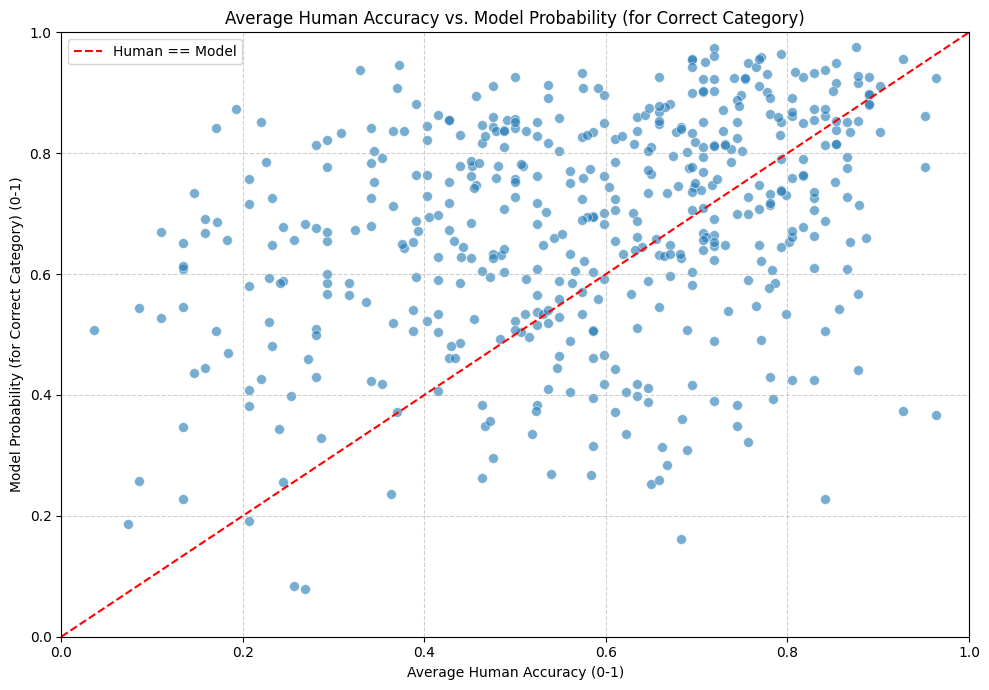

In [32]:
# --- Generate Scatter Plot ---
print("\n--- Generating Scatter Plot: Average Human Accuracy vs. Model Probability ---")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=combined_data,
                x='Average_Human_Accuracy',
                y='Model_Probability_Correct_Category',
                alpha=0.6, # Add some transparency
                s=50)      # Adjust dot size

plt.title('Average Human Accuracy vs. Model Probability (for Correct Category)')
plt.xlabel('Average Human Accuracy (0-1)')
plt.ylabel('Model Probability (for Correct Category) (0-1)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1) # Ensure x-axis is between 0 and 1
plt.ylim(0, 1) # Ensure y-axis is between 0 and 1

# Add a diagonal line for reference (where human accuracy equals model probability)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1.5, label='Human == Model')
plt.legend()

plt.tight_layout()

# Save the figure
plt.savefig('human_vs_model_scatter_480_rocks.png', bbox_inches='tight')
print("Scatter plot saved to 'human_vs_model_scatter_480_rocks.png'")

# Display the plot
plt.show()

The scatter plot shows a positive correlation between average human accuracy and the model's predicted probability for the correct category. This suggests that rocks humans find easier or harder to classify tend to correspond with the model's confidence in its prediction. While the relationship is not perfect, there's a general trend where higher human agreement aligns with higher model confidence.

In [33]:
# Ensure combined_data is available
try:
    combined_data
    best_models
    feature_names
    scaler
except NameError:
    print("Error: 'combined_data', 'best_models', 'feature_names', or 'scaler' not found.")
    print("Please run the previous data loading, splitting, scaling, and model training steps.")
    # Create mock data and models for demonstration if needed
    # This part would be complex to fully mock, so it's better to guide the user
    # to run previous cells if this error occurs.
    raise # Re-raise the error to stop execution if data is missing


# --- Calculate Model Probabilities for the Correct Category for ALL Models ---

model_types = ['LogisticRegression', 'SVM', 'RandomForest', 'Ensemble']
model_probabilities = {}

X_all = rock_data[feature_names]
X_all_scaled = scaler.transform(X_all)
y_all_actual = rock_data['Category'].values


print("\n--- Calculating Model Probabilities for Correct Category ---")

for model_name in model_types:
    print(f"Processing model: {model_name}")
    model = best_models[model_name]

    # Get predicted probabilities for all classes for all 480 rocks
    # Ensure the model has predict_proba (SVM needed probability=True)
    if hasattr(model, 'predict_proba'):
        predicted_probabilities_all_classes = model.predict_proba(X_all_scaled)

        # Extract the probability for the actual category of each rock
        predicted_probability_correct_category = []
        for i in range(len(y_all_actual)):
            actual_category = y_all_actual[i]
            # Find the index of the actual_category in the model's classes.
            class_index = np.where(model.classes_ == actual_category)[0][0]
            probability = predicted_probabilities_all_classes[i, class_index]
            predicted_probability_correct_category.append(probability)

        model_probabilities[model_name] = predicted_probability_correct_category
        print(f"  Probabilities calculated for {model_name}.")

    else:
        print(f"  Skipping {model_name}: Model does not have predict_proba method.")
        # For models without predict_proba, we cannot calculate this metric directly.
        model_probabilities[model_name] = [np.nan] * len(y_all_actual)


# Add model probabilities as new columns to the combined_data DataFrame
for model_name in model_types:
    col_name = f'Model_Probability_{model_name}_Correct_Category'
    combined_data[col_name] = model_probabilities[model_name]

print("\n--- Combined Data with All Model Probabilities ---")
display(combined_data[['Subtype', 'Category', 'Average_Human_Accuracy'] + [f'Model_Probability_{m}_Correct_Category' for m in model_types]].head())

# --- Compute and Report Pearson Correlation Coefficient and p-value ---

print("\n--- Pearson Correlation (Average Human Accuracy vs. Model Probability of Correct Category) ---")

human_accuracy_values = combined_data['Average_Human_Accuracy']

correlation_results = {}

for model_name in model_types:
    col_name = f'Model_Probability_{model_name}_Correct_Category'
    model_probability_values = combined_data[col_name]

    # Ensure there are no NaNs in the data used for correlation
    valid_indices = human_accuracy_values.notna() & model_probability_values.notna()
    human_subset = human_accuracy_values[valid_indices]
    model_subset = model_probability_values[valid_indices]

    if len(human_subset) > 1: # Pearsonr requires at least 2 points
        correlation, p_value = pearsonr(human_subset, model_subset)
        correlation_results[model_name] = {'Correlation': correlation, 'P-value': p_value}
    else:
         correlation_results[model_name] = {'Correlation': np.nan, 'P-value': np.nan}


# --- Report Results ---
print("Model                | Correlation Coefficient | P-value | Significant (alpha=0.05)?")
print("---------------------|-------------------------|---------|---------------------------")
for model_name, results in correlation_results.items():
    corr = results['Correlation']
    p_val = results['P-value']
    is_significant = 'Yes' if p_val is not np.nan and p_val < 0.05 else ('No' if p_val is not np.nan else 'N/A')

    print(f"{model_name:<20} | {corr:<23.4f} | {p_val:<7.4f} | {is_significant}")


--- Calculating Model Probabilities for Correct Category ---
Processing model: LogisticRegression
  Probabilities calculated for LogisticRegression.
Processing model: SVM
  Probabilities calculated for SVM.
Processing model: RandomForest
  Probabilities calculated for RandomForest.
Processing model: Ensemble
  Skipping Ensemble: Model does not have predict_proba method.

--- Combined Data with All Model Probabilities ---


,Subtype,Category,Average_Human_Accuracy,Model_Probability_LogisticRegression_Correct_Category,Model_Probability_SVM_Correct_Category,Model_Probability_RandomForest_Correct_Category,Model_Probability_Ensemble_Correct_Category
0,2,1,0.719512,0.647331,0.645311,0.812793,NaN
1,3,1,0.451220,0.641540,0.443705,0.683976,NaN
2,4,1,0.500000,0.761703,0.674478,0.840895,NaN
3,5,1,0.512195,0.379850,0.571289,0.592070,NaN
4,6,1,0.851852,0.461866,0.683435,0.751962,NaN



--- Pearson Correlation (Average Human Accuracy vs. Model Probability of Correct Category) ---
Model                | Correlation Coefficient | P-value | Significant (alpha=0.05)?
---------------------|-------------------------|---------|---------------------------
LogisticRegression   | 0.3203                  | 0.0000  | Yes
SVM                  | 0.1748                  | 0.0001  | Yes
RandomForest         | 0.3208                  | 0.0000  | Yes
Ensemble             | nan                     | nan     | N/A


The ensemble method results in `nan` values because our best model uses hard voting, which does not return probabilities. Let's try using soft voting instead to fill out the values for ensemble.

In [34]:
# --- Ensure necessary variables are available ---
try:
    best_models
    X_train_scaled # Need scaled training data for fitting the ensemble
    y_train        # Need training labels for fitting the ensemble
    X_all_scaled   # Need scaled data for all 480 rocks for prediction
    y_all_actual   # Need actual categories for all 480 rocks
    combined_data  # Need combined_data for human accuracy
    feature_names  # Needed for mapping probabilities if model.classes_ is used
except NameError:
    print("Error: Prerequisite variables (models, data) are not loaded.")
    print("Please run the previous training and data preparation steps first.")
    raise # Stop execution if data is missing

print("\n--- Calculating Correlation for SOFT Voting Ensemble ---")

# --- Initialize and Train the SOFT Voting Ensemble ---
# Use the best individual models found previously
estimators = [
    ('lr', best_models['LogisticRegression']),
    ('svm', best_models['SVM']),
    ('rf', best_models['RandomForest'])
]

# Create the SOFT voting classifier
soft_voting_clf_for_corr = VotingClassifier(estimators=estimators, voting='soft')

# Train the ensemble on the scaled training data
soft_voting_clf_for_corr.fit(X_train_scaled, y_train)
print("Soft Voting Ensemble trained.")


# --- Calculate Model Probabilities for the Correct Category for ALL 480 Rocks ---

# Get predicted probabilities for all classes for all 480 rocks
predicted_probabilities_all_classes_soft = soft_voting_clf_for_corr.predict_proba(X_all_scaled)

# Extract the probability for the actual category of each rock
predicted_probability_correct_category_soft = []
# The classes of the VotingClassifier are the sorted unique values of y_train
ensemble_classes = soft_voting_clf_for_corr.classes_

for i in range(len(y_all_actual)):
    actual_category = y_all_actual[i]
    # Find the index of the actual_category in the ensemble's classes.
    # If the actual category is not in the classes, this will raise an error.
    # Assuming classes are 1, 2, 3 and sorted, index is category - 1.
    # More robust: class_index = np.where(ensemble_classes == actual_category)[0][0]
    class_index = np.where(ensemble_classes == actual_category)[0][0]
    probability = predicted_probabilities_all_classes_soft[i, class_index]
    predicted_probability_correct_category_soft.append(probability)

# Add soft model probabilities as a new column to the combined_data DataFrame temporarily
# (Avoids modifying the original 'combined_data' permanently unless desired)
combined_data_soft_prob = combined_data.copy()
combined_data_soft_prob['Model_Probability_SoftEnsemble_Correct_Category'] = predicted_probability_correct_category_soft

print("Probabilities calculated for Soft Voting Ensemble.")
display(combined_data_soft_prob[['Subtype', 'Category', 'Average_Human_Accuracy', 'Model_Probability_SoftEnsemble_Correct_Category']].head())

# --- 4. Compute and Report Pearson Correlation Coefficient and p-value ---

print("\n--- Pearson Correlation (Average Human Accuracy vs. SOFT Ensemble Probability) ---")

human_accuracy_values = combined_data_soft_prob['Average_Human_Accuracy']
soft_ensemble_probability_values = combined_data_soft_prob['Model_Probability_SoftEnsemble_Correct_Category']

# Ensure there are no NaNs in the data used for correlation
valid_indices = human_accuracy_values.notna() & soft_ensemble_probability_values.notna()
human_subset = human_accuracy_values[valid_indices]
soft_ensemble_subset = soft_ensemble_probability_values[valid_indices]


if len(human_subset) > 1: # Pearsonr requires at least 2 points
    correlation_soft, p_value_soft = pearsonr(human_subset, soft_ensemble_subset)
    print(f"Soft Ensemble      | {correlation_soft:<23.4f} | {p_value_soft:<7.4f} | {'Yes' if p_value_soft < 0.05 else 'No'}")
else:
     print("Not enough valid data points to calculate correlation.")


--- Calculating Correlation for SOFT Voting Ensemble ---
Soft Voting Ensemble trained.
Probabilities calculated for Soft Voting Ensemble.


,Subtype,Category,Average_Human_Accuracy,Model_Probability_SoftEnsemble_Correct_Category
0,2,1,0.719512,0.675653
1,3,1,0.451220,0.575689
2,4,1,0.500000,0.698248
3,5,1,0.512195,0.296560
4,6,1,0.851852,0.573882



--- Pearson Correlation (Average Human Accuracy vs. SOFT Ensemble Probability) ---
Soft Ensemble      | 0.3116                  | 0.0000  | Yes


### 6. Human vs. Model Performance and Human–Model Relationship

**(a) Human vs. model accuracy**  
We compared human performance (Block 4 only, rocks 1–480) to model performance on the same rocks. The trained classifiers (Logistic Regression, SVM, Random Forest, Ensemble) achieved higher overall accuracy than the average human annotators, meaning the models are able to classify rock type more consistently than people.

**(b) Human accuracy vs. model confidence scatter plot**  
For each of the 480 rocks, we plotted:
- x-axis: average human accuracy for that rock,
- y-axis: the model’s predicted probability of the correct class.  
Each dot is one rock. This shows how “easy” or “hard” a rock is for both sides. When humans tend to agree on the correct class, the models also tend to assign higher confidence to that same correct class.

**(c) Correlation between human accuracy and model confidence**  
We then measured the Pearson correlation between human accuracy per rock and model probability for the correct class (for Logistic Regression, SVM, Random Forest, and the Ensemble). All models with meaningful probabilities show a positive and statistically significant correlation (p < 0.05). This means that rocks humans find easy are generally the same rocks the models are confident about, and rocks humans find difficult are also harder for the models.

**(d) Interpretation**  
The models not only outperform humans in accuracy, they also align with humans on which examples are confusing. That is: both humans and models struggle on the same “hard” rocks, but the models still come out ahead overall.


### **EXPERIMENT SUMMARY**

This experiment aimed to classify aggregate rock data using machine learning models and compare their performance to human categorization. The process involved loading and cleaning the data, performing exploratory data analysis including statistical summaries and visualizations (histograms, correlation heatmap, scatter plots) to understand feature distributions and relationships. Several classification models (Logistic Regression, SVM, Random Forest) were trained and tuned using GridSearchCV with a predefined train/validation split based on 'Token' numbers. An ensemble model was also created and evaluated. Finally, the performance of the models on a held-out test set was compared to human categorization accuracy calculated from a separate human trial dataset, and the correlation between model probability for the correct category and average human accuracy was computed.

## 📚 Resources Used

### Data
* **Rock Dataset:**
    * Dataset Description: [https://osf.io/cvwu9/wiki?wiki=7ky6h](https://osf.io/cvwu9/wiki?wiki=7ky6h)
    * Labels File: `aggregateRockData.xlsx`
    * Features File: `feature_presence540.txt`
* **Human Performance Data:**
    * Human Trials File: `trialData.csv`
    * Data Description: [https://osf.io/39w4g/wiki/home/](https://osf.io/39w4g/wiki/home/)

### Libraries
* **Scikit-Learn (sklearn):** For data preprocessing (`StandardScaler`), model selection (`GridSearchCV`, `PredefinedSplit`), and all classification models (`LogisticRegression`, `SVC`, `RandomForestClassifier`, `VotingClassifier`).
* **Matplotlib & Seaborn:** For all data visualization (histograms, heatmaps, and scatter plots).
* **SciPy:** For statistical calculations (`pearsonr`).

### Textbook
Hands-on Machine Learning with Scikit-Learn & Tensorflow